In [204]:
from lib.data import Mimic2
import numpy as np
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss, wridge, wlasso, lasso, ridge, owl, r4rr
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, reg_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from lib.openbox import open_box, count_config, find_x, open_box_batch, find_all_x

In [178]:
raw_data = []
for fn in glob.glob('models/test*.pkl'):
    name = fn.split('/')[-1].split('.pkl')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])

df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(rec, prec)', 'sparsity'])
print(df.sort_values(['auc'], ascending=False))

  method name alpha       auc        ap  min(rec, prec)  sparsity
0   eye_loss*  0.01  0.812620  0.682140        0.444444  0.400321
1    wlasso3*  0.01  0.803364  0.645336        0.413043  0.497809


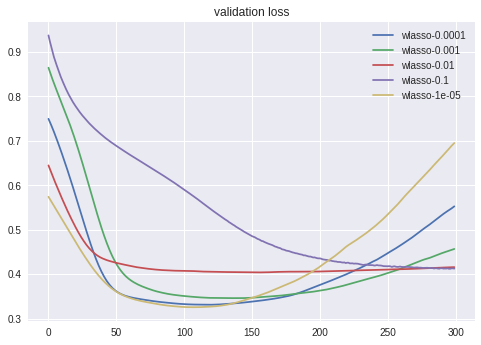

In [175]:
for fn in glob.glob('models2/wlasso^*.valloss.npy'):
    name = fn.split('/')[-1].split('.valloss')[0]
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    losses = np.load(fn)
    plt.title("validation loss")
    plt.plot(losses, label="%s-%s" % (name, alpha))
    
plt.legend()
plt.show()

# find out how many classifiers (LLC) are there

In [185]:
m = Mimic2(duplicate=1)
train_data = TensorDataset(*map(lambda x: x.data, prepareData(m.xtrain, m.ytrain)))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [187]:
net = torch.load('models/testwlasso3^0.01.pt')
config_counter = count_config(net, train_loader)

100%|██████████| 36/36 [00:01<00:00, 27.00it/s]


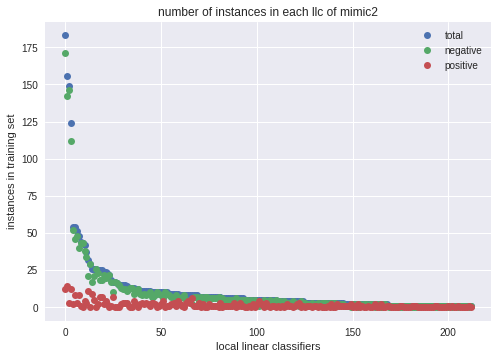

In [199]:
sorted_configs = sorted(map(lambda x: (x[0], sum(x[1].values()), x[1][0], x[1][1]), 
                                    config_counter.items()), 
                                key=lambda x: x[1], reverse=True)

plt.plot(list(map(lambda x: x[1], sorted_configs)), 'o', label='total')
plt.plot(list(map(lambda x: x[2], sorted_configs)), 'o', label='negative')
plt.plot(list(map(lambda x: x[3], sorted_configs)), 'o', label='positive')

plt.title('number of instances in each llc of mimic2')
plt.xlabel('local linear classifiers')
plt.ylabel('instances in training set')
plt.legend()
plt.show()

In [205]:
top = 0
x = find_all_x(sorted_configs[top][0], net, train_loader)

In [202]:
len(sorted_configs), len(m.xtrain)

(213, 2250)

/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


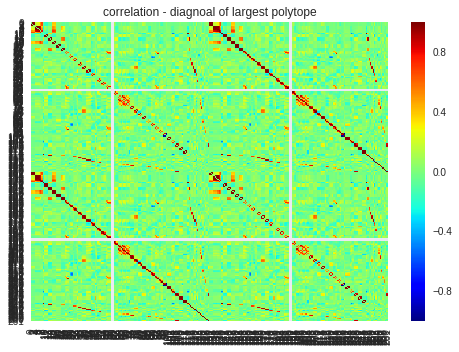

In [245]:
corr = np.corrcoef(x.data.numpy().T)
plt.title('correlation - diagnoal of largest polytope')
sns.heatmap(corr - np.diag(np.diag(corr)), cmap='jet')
plt.show()

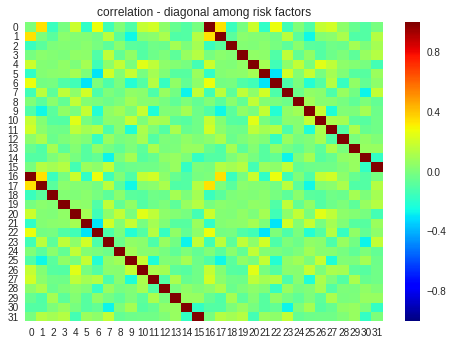

In [214]:
indices = m.r.nonzero().view(-1)
sub_corr = corr[indices][:, indices]
sns.heatmap(sub_corr - np.diag(np.diag(sub_corr)), cmap='jet', vmin=-1, vmax=1)
plt.title('correlation - diagonal among risk factors')
plt.show()

In [217]:
W, b, C = open_box(net, x[0])

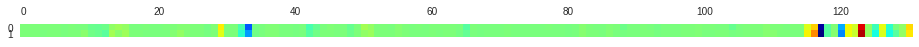

In [244]:
expl = (W[1] - W[0]).data.numpy()
expl_max = np.max(np.abs(expl))
plt.matshow(expl.reshape(2,-1),cmap='jet', vmin=-expl_max, vmax=expl_max)
plt.grid(False)
plt.show()

# calculate correlation among variables

In [123]:
m = Mimic2(duplicate=1)
m.xtrain.shape

(2250, 262)

/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jiaxuan/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


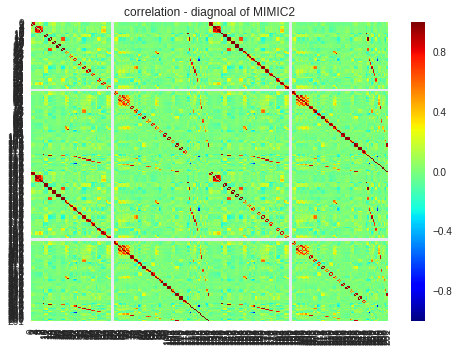

In [126]:
corr = np.corrcoef(m.xtrain.T)
plt.title('correlation - diagnoal of MIMIC2')
sns.heatmap(corr - np.diag(np.diag(corr)), cmap='jet')
plt.show()

In [138]:
corr[m.r.nonzero().view(-1), :].shape

(32, 262)

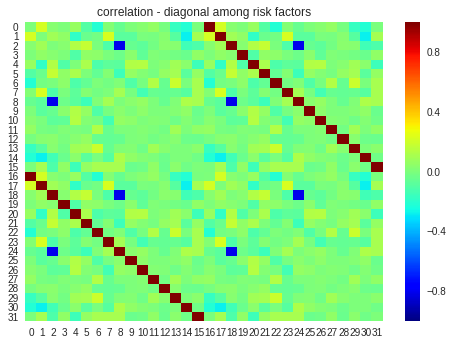

In [139]:
indices = m.r.nonzero().view(-1)
sub_corr = corr[indices][:, indices]
sns.heatmap(sub_corr - np.diag(np.diag(sub_corr)), cmap='jet', vmin=-1, vmax=1)
plt.title('correlation - diagonal among risk factors')
plt.show()

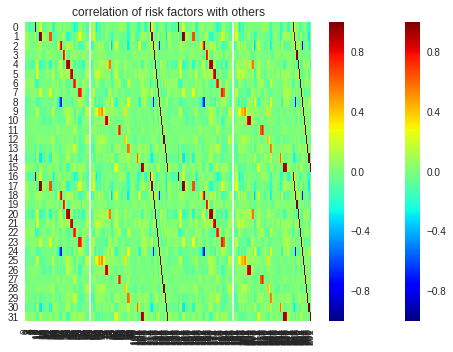

In [148]:
sub_corr = corr[indices]
plt.title('correlation of risk factors with others')
sns.heatmap(sub_corr, cmap='jet', vmin=-1, vmax=1)
plt.show()

In [146]:
-np.log(0.59)

0.52763274208237199